In [ ]:
!pip install -q --upgrade tensorflow_hub
!pip install -q tensorflow_text
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 29.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import tensorflow_text as text
from matplotlib import pyplot as plt
from official.nlp import optimization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BERT Recommender System/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
from bs4 import BeautifulSoup

def remove_html(text_data):
  soup = BeautifulSoup(text_data, 'lxml')
  return soup.get_text()

df['review'] = df['review'].apply(remove_html)

<ipython-input-7-a747e80b88b9>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text_data, 'lxml')


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
X = df.drop('sentiment',axis = 1)
y = df['sentiment']

In [ ]:
y = y.apply(lambda x: 1 if x=="positive" else 0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)
print("X_train = " , X_train.shape)
print("y_train = " , y_train.shape)
print("X_test = " , X_test.shape)
print("y_test = " , y_test.shape)

X_train =  (40000, 1)
y_train =  (40000,)
X_test =  (10000, 1)
y_test =  (10000,)


In [ ]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [ ]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)

In [ ]:
bert_model = hub.KerasLayer(encoder_url)

In [ ]:
def build_model():
  #Input Layer
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

  #preprocessing text to convert tokens using bert preprocessor
  preprocessing_layer = hub.KerasLayer(preprocess_url, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)

  #encoding recieved preprocess text to get self attention matrix
  encoder = hub.KerasLayer(encoder_url, trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)

  layer = outputs['pooled_output']

  layer = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(layer)

  return tf.keras.Model(text_input, layer)

In [ ]:
text_test = ['I hate you','I love you']
model = build_model()
bert_raw_result = model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.57568586]
 [0.563907  ]], shape=(2, 1), dtype=float32)


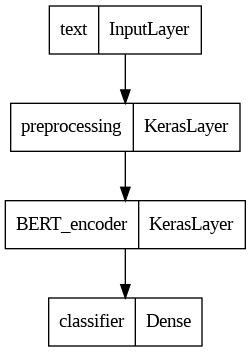

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
                         loss=loss,
                         metrics=METRICS)

In [ ]:
history = model.fit (X_train,y_train,
                     epochs=10,
                     batch_size = 32,
                     )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1250/1250 [==============================] - 442s 346ms/step - loss: 0.5876 - accuracy: 0.6981 - precision: 0.7025 - recall: 0.6850
Epoch 2/10
1250/1250 [==============================] - 443s 354ms/step - loss: 0.5205 - accuracy: 0.7523 - precision: 0.7587 - recall: 0.7387
Epoch 3/10
1250/1250 [==============================] - 443s 354ms/step - loss: 0.4959 - accuracy: 0.7667 - precision: 0.7731 - recall: 0.7537
Epoch 4/10
1250/1250 [==============================] - 444s 355ms/step - loss: 0.4827 - accuracy: 0.7724 - precision: 0.7781 - recall: 0.7608
Epoch 5/10
1250/1250 [==============================] - 448s 358ms/step - loss: 0.4742 - accuracy: 0.7789 - precision: 0.7838 - recall: 0.7690
Epoch 6/10
1250/1250 [==============================] - 450s 360ms/step - loss: 0.4665 - accuracy: 0.7808 - precision: 0.7871 - recall: 0.7685
Epoch 7/10
1250/1250 [==============================] - 448s 359ms/step - loss: 0.4614 - accuracy: 0.7850 - precision: 0.7906 - recall: 0.7743
Epoch 8/10

In [ ]:
model.save('/content/drive/MyDrive/BERT Recommender System/BERT_Finetuned_IMDB.h5')

In [ ]:
model.evaluate(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 108s 340ms/step - loss: 0.4504 - accuracy: 0.7881 - precision: 0.8227 - recall: 0.7386


[0.45035579800605774,
 0.788100004196167,
 0.8227232694625854,
 0.7386386394500732]

In [ ]:
model_trained = tf.keras.saving.load_model(
    '/content/drive/MyDrive/BERT Recommender System/BERT_Finetuned_IMDB.h5',
    custom_objects={'KerasLayer':hub.KerasLayer}
)

In [ ]:
y_pred = model_trained.predict(X_test)

313/313 [==============================] - 109s 337ms/step


array([0.60035694, 0.7622226 , 0.16169895, ..., 0.64126426, 0.47375098,
       0.11579408], dtype=float32)

In [ ]:
for i in range(y_pred.shape[0]):
  if y_pred[i][0] > 0.5 :
    y_pred[i][0] = 1
  else:
    y_pred[i][0] = 0

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
y_test

33553    1
9427     1
199      0
12447    1
39489    0
        ..
28567    0
25079    1
18707    1
15200    0
5857     1
Name: sentiment, Length: 10000, dtype: int64

In [ ]:
print(classification_report(y_test,y_pred,target_names=['Positive','Negative']))

              precision    recall  f1-score   support

    Positive       0.76      0.84      0.80      4961
    Negative       0.82      0.74      0.78      5039

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [ ]:
cm=confusion_matrix(y_test,y_pred,labels=[0,1])
print(cm)

[[4159  802]
 [1317 3722]]


<Axes: >

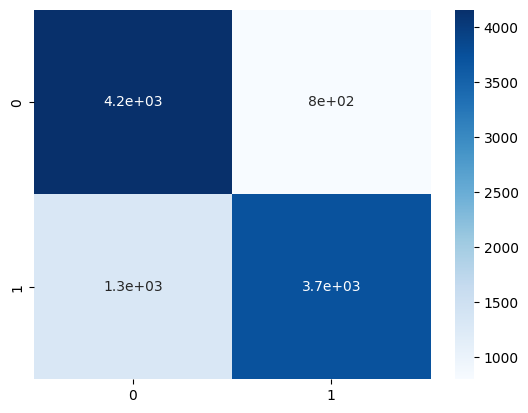

In [ ]:
sns.heatmap(cm,annot=True,cmap='Blues')

In [ ]:
def predict_review(review):
  test_predicted = model_trained.predict(review)

  for i in range(test_predicted.shape[0]):
    if test_predicted[i][0] > 0.5:
      print(pred_sentences[i],": Positive ")
    else:
      print(pred_sentences[i],": Negative ")


In [ ]:
pred_sentences = ['worst movie of my life, will never watch movies from this series', 'Wow, blew my mind, what a movie by Marvel, animation and story is amazing']

predict_review(pred_sentences)

1/1 [==============================] - 0s 64ms/step
worst movie of my life, will never watch movies from this series : Negative 
Wow, blew my mind, what a movie by Marvel, animation and story is amazing : Positive 


In [ ]:
my_movie = ["The cinematic scenes of tiger 3 is fabulous and animatic but the story behind the movie is not up to the mark just like the rusty iron.The dialogus used in the movie harsh"]

predict_review(my_movie)

1/1 [==============================] - 0s 131ms/step
worst movie of my life, will never watch movies from this series : Negative 


In [ ]:
my_movie = ["The cinematic scenes of tiger 3 is good and animatic but the story behind the movie is not up to the mark just like the rusty iron.The dialogus used in the movie bad and climex was good"]

predict_review(my_movie)

1/1 [==============================] - 0s 59ms/step
worst movie of my life, will never watch movies from this series : Negative 
